In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
import nawrapper.ps as nw
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot

# File Loading

We specify the filepaths here. In the first cell, we load in a map which has the WCS and shape information, with which we will crop all other maps to fit. When we take power spectra, we want all of the maps involved to have the same shape and WCS!

In [3]:
data_root = '/tigress/zequnl/cmb/data/from_choi/'
apopath = f'{data_root}/apo_mask/deep56_c7v5_car_190220_rect_master_apo_w0.fits'
steve_apo = enmap.read_map(apopath)
box_shape, box_wcs = steve_apo.shape, steve_apo.wcs

Next, we load in the maps and masks. In this example, the same mask is used to speed up the spectra calculation, but in general each map will have a different mask. We also apply the k-space filter at this step, with $|k_x| < 90$ and $|k_y| < 50$.

### Legacy Support
There is an important flag here, `legacy_steve = True`. At the time of this writing, Steve's code applies a slightly incorrect k-space filter, and offsets the maps by `(-1,-1)` in `WCS.CRPIX`.

In [4]:
mapname_head = f"{data_root}/maps/ACTPol_148_D56_pa1_f150_s14_4way_split"
mask_file =  f"{data_root}/window/deep56_s14_pa1_f150_c7v5_car_190220_rect_w0_cl0.00nK_pt1.00_nt0.0_T.fits"
beam_filename = f"{data_root}/beam/beam_tform_160201_s14_pa1_f150_jitter_CMB_deep56.txt"

# loop over splits and generate 
nsplits = 4
namap_list = [nw.namap(box_shape, box_wcs, 
                       map_file=f"{mapname_head}{i}_srcadd_I.fits",
                       mask_file=mask_file, 
                       beam_file=beam_filename, 
                       legacy_steve=True,
                       kx=90, ky=50)
              for i in range(nsplits)]

Next, we compute the mode coupling matrix from the first two fields. We will reuse this for all spectra calculations.

In [5]:
binfile = f'{data_root}/binning/BIN_ACTPOL_50_4_SC_low_ell'
bins = nw.get_bins_from_file(binfile)
mc = nw.mode_coupling(namap_list[0], namap_list[1], bins)

Next, we apply the mode coupling matrix to each pair of `namap` objects. We will reuse the mode coupling object we computed, since all the masks are the same in this toy example. We take a flat mean of the 4 choose 2 = 6 cross spectra, and also compute the standard error.

In [6]:
spectra_dict, cross_spectra = nw.get_cross_spectra(namap_list, bins, mc)
mean_Cltt = np.sum(cross_spectra, axis=0) / len(cross_spectra)
se_Cltt = np.std(cross_spectra, axis=0)/np.sqrt(len(cross_spectra))

# Check Our Results

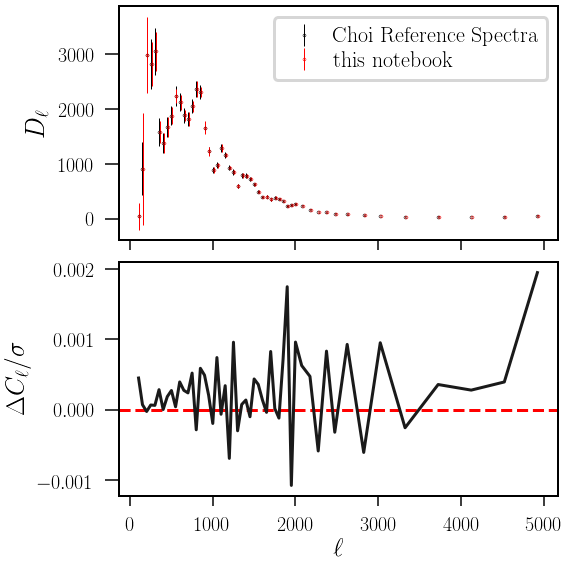

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(8,8), sharex=True)

# plot steve spectra
specfile = f"{data_root}/ps/deep56_s14_pa1_f150_c7v5_car_190220_rect_window0_TT_lmax7925_fsky0.01081284_output.txt"
choi_ell, choi_dl, choi_delta_dl, _ = np.loadtxt(specfile, unpack=True)[:,2:54]
axes[0].errorbar( choi_ell, choi_dl, yerr=choi_delta_dl, fmt='k.', 
                 lw=1, ms=1, label="Choi Reference Spectra" )
# plot our spectra
lb = mc.lb[1:-3]
notebook_dl = mean_Cltt[1:-3] 
axes[0].errorbar(lb + 10, notebook_dl, # we slightly offset to not overlap
                 fmt='r.', 
                 yerr=(notebook_dl / np.sqrt(2 * lb + 1) + se_Cltt[1:-3]),
                 lw=1, ms=1, label="this notebook")
axes[0].set_ylabel(r"$D_{\ell}$")
axes[0].legend(frameon=True)

# plot ratio
axes[1].axhline(0.0, ls='dashed', color='red')
axes[1].plot( lbs, (notebook_dl - choi_dl) / choi_delta_dl )
axes[1].set_ylabel('$ \Delta C_{\ell} / \sigma$')
axes[1].set_xlabel(r'$\ell$')
plt.tight_layout()